In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

import random
import string
import seaborn as sns
import os
import numpy as np
import timeit

In [2]:
model_logs_root = '/Users/rohan/Documents/python-projects/deepracer/2022-October/Logs-SteerSpeedDist-Diff-8Hours'
log = DeepRacerLog(model_logs_root)

# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '4'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.999,
 'e_greedy_value': 0.05,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0003,
 'num_episodes_between_training': 20,
 'num_epochs': 10,
 'stack_size': 1,
 'term_cond_avg_score': 350000000.0,
 'term_cond_max_episodes': 1000000000}
-------------
{'speed': {'high': 1.0, 'low': 0.5},
 'steering_angle': {'high': 30.0, 'low': -30.0}}


In [3]:
track_path = "/Users/rohan/Documents/python-projects/deepracer/deepracer-k1999-race-lines/tracks/"
ListFiles = [f for f in os.listdir(track_path) if os.path.isfile(os.path.join(track_path, f))]
print(ListFiles)

['reInvent2019_track.npy', '2022_august_open.npy', 'Canada_Training.npy', 'canada_race.npy', 'Tokyo_Training_track.npy', 'Oval_track.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'H_track.npy', 'reinvent_base.npy', '2022_september_open.npy', 'Mexico_track.npy', 'Virtual_May19_Train_track.npy', 'Straight_track.npy', 'AWS_track.npy', 'China_track.npy', '2022_july_open.npy', '2022_june_open.npy', 'London_Loop_Train.npy']


In [4]:
def get_track_waypoints(track_name):
    return np.load("%s/%s.npy" % (track_path, track_name))

trackname="2022_september_open"
waypoints = get_track_waypoints(trackname)
waypoints.shape

(152, 6)

In [5]:
center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [6]:
def plot_track(ax):
    ax.plot(inner_border[:, 0], inner_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(outer_border[:, 0], outer_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(inner_border[:, 0], inner_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    ax.plot(outer_border[:, 0], outer_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

In [7]:
from numpy import array

fname = '../deepracer-k1999-race-lines/racelines/2022_september_open-2000-4-2022-10-23-145109.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
racing_line = deserialized
racing_line.shape

(152, 2)

In [8]:
def plot_racing_line(ax, zdot=1, zline=2):
    ax.plot(racing_line[:, 0], racing_line[:, 1], '.', color='#646464', zorder=zdot)
    ax.plot(racing_line[:, 0], racing_line[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=zline)

In [9]:
npoints = len(racing_line) - 1

In [13]:
episode_num = 435
custom_df = df[df['episode'] == episode_num]
start = custom_df.index[0]

step = 4
dist = np.zeros(len(custom_df))
x_coords = np.zeros(len(custom_df))
y_coords = np.zeros(len(custom_df))
idx = 0

for ep in custom_df['episode'].unique():
    prv = np.roll(custom_df.index[custom_df['episode'] == ep], 1) - start
    cur = np.roll(custom_df.index[custom_df['episode'] == ep], 0) - start
    if custom_df.iloc[prv[0]]['progress'] == 100:
        for i in range(step, len(cur) - step, step):
            coords = custom_df.iloc[cur[i] - step:cur[i] + step + 1][['x', 'y']].to_numpy()
            distances_to_waypoints = np.hypot(racing_line[:npoints, 0:1].T - coords[:, 0:1], racing_line[:npoints, 1:2].T - coords[:, 1:2])
            dist[idx] = np.amin(distances_to_waypoints, axis=1).mean()
            x_coords[idx] = custom_df.iloc[cur[i]]['x']
            y_coords[idx] = custom_df.iloc[cur[i]]['y']
            idx += 1

0.05289432438709759
0.3147693509748106


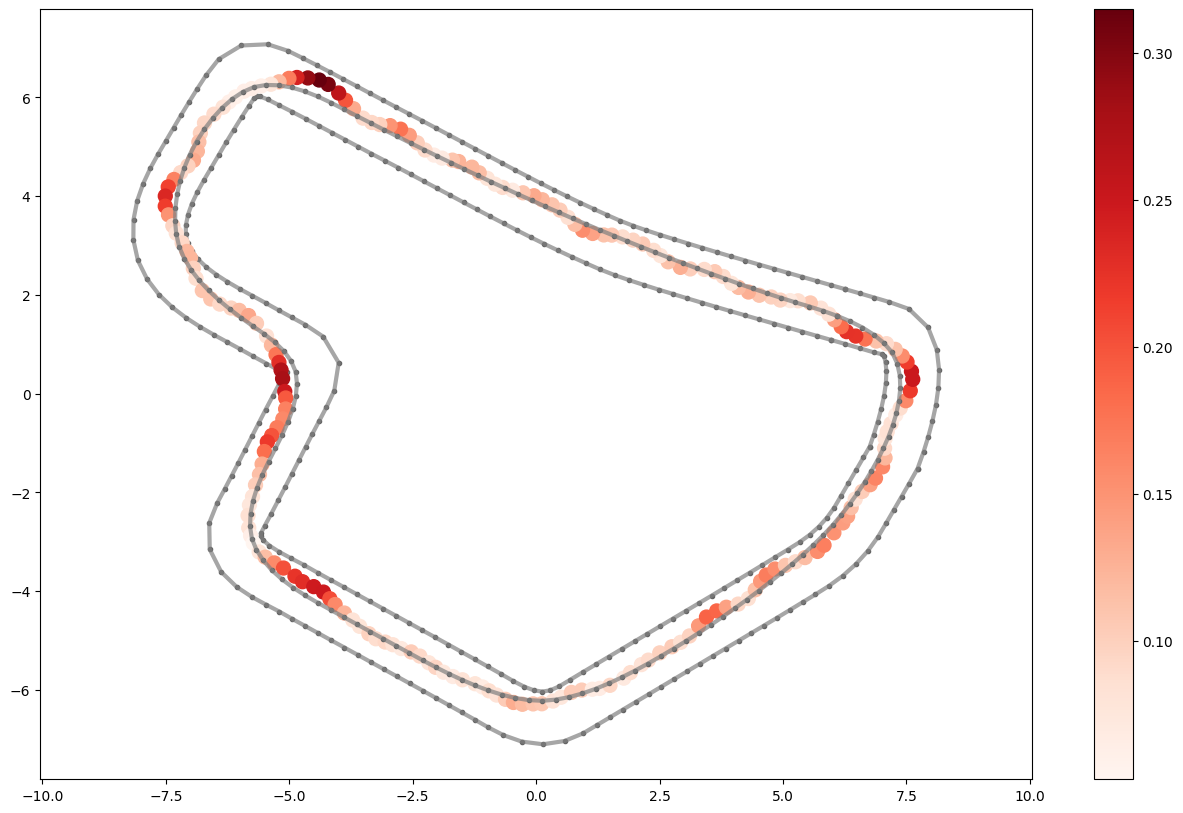

In [14]:
print(dist[:idx].min())
print(dist[:idx].max())

fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
scatter = ax.scatter(
    x_coords[:idx], y_coords[:idx], s=100,
    c=dist[:idx], cmap='Reds', zorder=3
)
plot_racing_line(ax, 4, 5)
fig.colorbar(scatter)

In [12]:
df[df['episode'] == episode_num]

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode
128052,435,1.0,1.738565,-5.787596,30.831350,-8.808900,0.584326,-1,0.000000,False,True,0.310290,113,45.297382,12734.272,prepare,0.0,21,0,435
128053,435,2.0,1.739004,-5.787821,30.725686,-9.045951,0.842679,-1,0.000000,False,True,0.310868,113,45.297382,12734.342,in_progress,0.0,21,0,435
128054,435,3.0,1.738136,-5.787806,30.833915,23.421055,0.707550,-1,-0.030611,False,True,0.309239,113,45.297382,12734.403,in_progress,0.0,21,0,435
128055,435,4.0,1.769687,-5.764926,31.527935,24.480837,0.808167,-1,1.690376,False,True,0.394930,113,45.297382,12734.455,in_progress,0.0,21,0,435
128056,435,5.0,1.774948,-5.760816,31.706533,13.055876,0.794871,-1,0.307022,False,True,0.409551,113,45.297382,12734.527,in_progress,0.0,21,0,435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128896,435,845.0,1.495006,-5.905822,13.751420,21.570979,0.626103,-1,1.219995,False,True,99.714794,112,45.297382,12790.855,in_progress,0.0,21,0,435
128897,435,846.0,1.533131,-5.889117,15.438814,4.767888,0.845891,-1,2.045933,False,True,99.805973,112,45.297382,12790.906,in_progress,0.0,21,0,435
128898,435,847.0,1.576033,-5.869228,17.202225,8.795073,0.513415,-1,1.894774,False,True,99.909809,112,45.297382,12790.977,in_progress,0.0,21,0,435
128899,435,848.0,1.608844,-5.853414,18.480958,21.110989,0.965503,-1,1.675274,False,True,99.989903,112,45.297382,12791.018,in_progress,0.0,21,0,435
